# Model training and prediction - `s30d`

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [9]:
import numpy as np
import pandas as pd

In [10]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d
tc_test = pd.read_csv("./data/processed/s30d/tc_test.csv", index_col = 0).tc

In [11]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [12]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [13]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [14]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [62]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:5]
}

In [63]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [91]:
lgbm = Pipeline(steps=[("lightgbmclassifier", LGBMClassifier())])
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    lgbm,
    lr,
    rf
]

In [92]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [93]:
from src.models.classifiers import StackedGeneralizationClassifier

In [94]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Outer loop, each fold:
	Number of 0's: ~2930 (94.18%)
	Number of 1's: ~181 (5.82%)
Inner loop, each loop:
	Number of 0's: ~1465 (94.18%)
	Number of 1's: ~90 (5.82%)


In [95]:
y_test_pred_con, y_test_pred_cut = sgclf.predict(X_test)

In [96]:
from sklearn.metrics import roc_auc_score

In [97]:
("Hold-out AUC of ROC, continous model: " + 
str(roc_auc_score(y_score = y_test_pred_con, y_true = y_test)))

'Hold-out AUC of ROC, continous model: 0.9553522688502218'

In [98]:
("Hold-out AUC of ROC, cut model: " + 
str(roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)))

'Hold-out AUC of ROC, cut model: 0.9157732002729444'

In [99]:
from src.visualization.visualize import plot_roc, plot_precision_recall

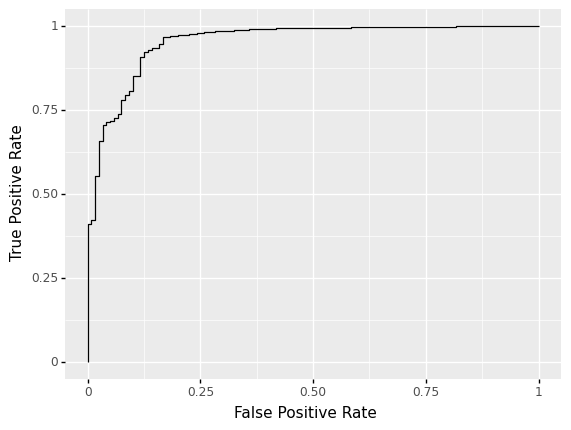

<ggplot: (692297539)>

In [100]:
plot_roc(y_test, y_test_pred_con)

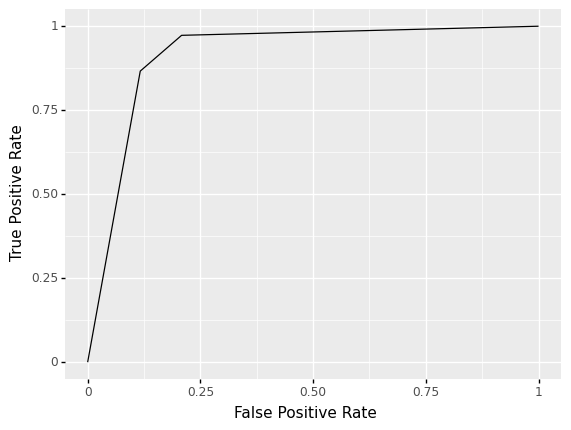

<ggplot: (396091510)>

In [101]:
plot_roc(y_test, y_test_pred_cut)

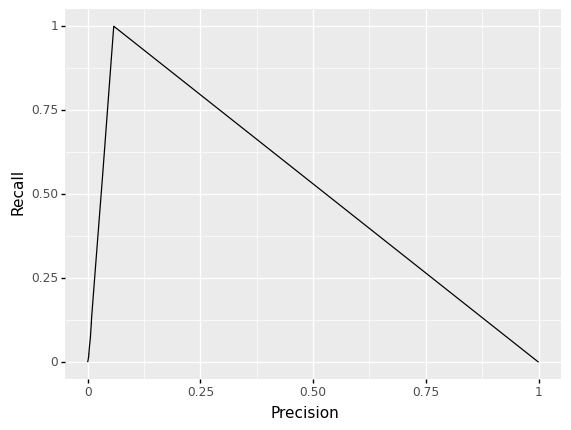

<ggplot: (395963128)>

In [102]:
plot_precision_recall(y_test, y_test_pred_con)

Plot roc curves for each classifier

In [103]:
from src.visualization.visualize import plot_roc_base_clfs

In [104]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [105]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [107]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [108]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [109]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_pred_con))

In [113]:
from src.models.metrics import calculate_nri

In [124]:
y_test_pred_clfs

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [194]:
def compute_performance(y_prob, y_pred, y_true):
    roc_auc = roc_auc_score(
        y_true=y_true, 
        y_score=y_prob
    )
    prec = precision_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    rec = recall_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    return dict(roc_auc = roc_auc, prec = prec, rec = rec)


def compile_performance(y_probs: pd.DataFrame, y_preds: pd.DataFrame,
                        y_true: np.array, tc: np.array, y_cut: np.array,
                        keys: list):
    # Compute prec, rec, auc for all models
    ds = [
        compute_performance(y_prob=prob, y_pred=pred, y_true=y_true) 
        for prob, pred in zip(y_probs.T, y_preds.T)
    ]
    perf_df = pd.DataFrame(ds, index = keys)
    
    # Compute nri for meta classifier
    nri_metrics = ["nri", "nri_plus", "nri_minus"]
    nri = calculate_nri(
        y_true=y_true, 
        y_old=tc, 
        y_new=y_cut
    )
    nri_df = pd.DataFrame(
        np.zeros(perf_df.shape),
        columns=nri_metrics    
    ).replace({0: None})
    nri_df.loc[len(perf_df.index) - 1, :] = np.array(nri[nri_metrics])
    nri_df.index = perf_df.index

    perf_df = pd.concat([perf_df, nri_df], axis = 1)

    return perf_df

In [195]:
compile_performance(
    y_preds=y_test_pred_clfs, 
    y_probs=y_test_prob_clfs, 
    y_true=y_test, 
    tc=tc_test,
    y_cut=y_test_pred_cut,
    keys=keys + [sgclf.__class__.__name__]
)

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



                 Estimate
NRI            0.31190720
NRI+           0.36666667
NRI-          -0.05475947
Pr(Up|Case)    0.42500000
Pr(Down|Case)  0.05833333
Pr(Down|Ctrl)  0.06243603
Pr(Up|Ctrl)    0.11719550


,roc_auc,prec,rec,nri,nri_plus,nri_minus
LGBMClassifier,0.947586,0.880664,0.786805,None,None,None
LogisticRegression,0.956158,0.876429,0.798793,None,None,None
RandomForestClassifier,0.939620,0.882001,0.803216,None,None,None
StackedGeneralizationClassifier,0.955352,0.900741,0.808406,0.311907,0.366667,-0.054759


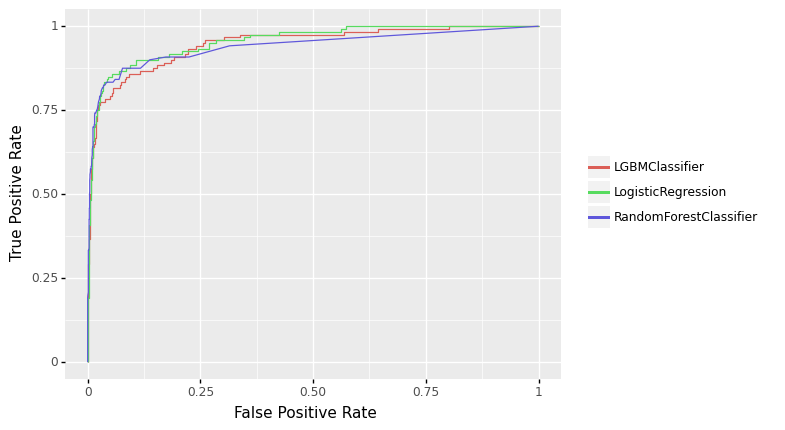

<ggplot: (396112299)>

In [112]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [39]:
tc_test = pd.read_csv("./data/processed/s30d/tc_test.csv", index_col = 0).tc

In [41]:
nri = calculate_nri(
    y_true=y_test.to_numpy(), 
    y_old=tc_test.to_numpy(), 
    y_new=y_test_pred_cut
) 

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



                 Estimate
NRI            0.34976970
NRI+           0.42500000
NRI-          -0.07523030
Pr(Up|Case)    0.47500000
Pr(Down|Case)  0.05000000
Pr(Down|Ctrl)  0.05834186
Pr(Up|Ctrl)    0.13357216
